In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd

In [3]:
#mrna_z = pd.read_csv('/gdrive/My Drive/project/data_mRNA_median_Zscores.csv',  sep='\t')
mrna_z = pd.read_csv('/gdrive/My Drive/project/data_mRNA_median_all_sample_Zscores.csv',  sep='\t')
mrna = pd.read_csv('/gdrive/My Drive/project/data_expression_median.csv',  sep='\t')
clinical = pd.read_csv('/gdrive/My Drive/project/data_clinical_patient.csv',  sep='\t', error_bad_lines=False)
clinical_sample = pd.read_csv('/gdrive/My Drive/project/data_clinical_sample.csv',  sep='\t', error_bad_lines=False)

mrna_z_transposed = mrna_z.transpose()
mrna_z_transposed.columns = mrna_z_transposed.iloc[0]
mrna_z_transposed = mrna_z_transposed.drop(mrna_z_transposed.index[0])

mrna_transposed = mrna.transpose()
mrna_transposed.columns = mrna_transposed.iloc[0]
mrna_transposed = mrna_transposed.drop(mrna_transposed.index[0])

In [4]:
all_clinical = pd.merge(clinical, clinical_sample, on='#Patient Identifier')
reduced_clinical = all_clinical[["#Patient Identifier", "Sample Identifier", "Diagnosis Age (days)", "Diagnosis Age", "INSS Stage", "Tumor Sample Histology", 
                                 "EFS Time", "Sex", "Risk Group", "Overall Survival Status", "Overall Survival Days", "MYCN", "Ploidy"]]

covid_genes_mrna_z = mrna_z_transposed[["ACE2", "IFITM3", "TMPRSS2", "MYCN"]]
covid_genes_mrna_z = covid_genes_mrna_z.reset_index()
covid_genes_mrna_z = covid_genes_mrna_z.rename(columns={'index': 'Sample Identifier'})
clinical_covid_genes_mrna_z = pd.merge(reduced_clinical, covid_genes_mrna_z, on='Sample Identifier')

paper_genes_mrna_z = mrna_z_transposed[["NTRK1", "TP53", "PTPN6"]]
paper_genes_mrna_z = paper_genes_mrna_z.reset_index()
paper_genes_mrna_z = paper_genes_mrna_z.rename(columns={'index': 'Sample Identifier'})
clinical_paper_genes_mrna_z = pd.merge(reduced_clinical, paper_genes_mrna_z, on='Sample Identifier')

paper_genes_mrna = mrna_transposed[["NTRK1", "TP53", "PTPN6"]]
paper_genes_mrna = paper_genes_mrna.reset_index()
paper_genes_mrna = paper_genes_mrna.rename(columns={'index': 'Sample Identifier'})
clinical_paper_genes_mrna = pd.merge(reduced_clinical, paper_genes_mrna, on='Sample Identifier')

In [53]:
#Set up binary/numerical classes for Cox regression
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Overall Survival Status"] == "1:DECEASED", 'dead'] = 1
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Overall Survival Status"] == "0:LIVING", 'dead'] = 0

clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 1", 'Stage'] = 0
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 2a", 'Stage'] = 1
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 2b", 'Stage'] = 2
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 3", 'Stage'] = 3
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 4", 'Stage'] = 4
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["INSS Stage"] == "Stage 4s", 'Stage'] = 5

clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Tumor Sample Histology"] == "Unfavorable", 'Histology'] = 0
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Tumor Sample Histology"] == "Favorable", 'Histology'] = 1
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Tumor Sample Histology"] == "Unknown", 'Histology'] = 3

clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Sex"] == "Female", 'Sex_binary'] = 0
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["Sex"] == "Male", 'Sex_binary'] = 1

clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["MYCN"] == "Not Amplified", 'mycn_binary'] = 0
clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z["MYCN"] == "Amplified", 'mycn_binary'] = 1

In [54]:
#Drop subjects with null values
clinical_paper_genes_mrna_z = clinical_paper_genes_mrna_z.dropna(subset=["Diagnosis Age (days)", "Histology", "Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "Overall Survival Status"])

In [55]:
clinical_paper_genes_mrna_z

,#Patient Identifier,Sample Identifier,Diagnosis Age (days),Diagnosis Age,INSS Stage,Tumor Sample Histology,EFS Time,Sex,Risk Group,Overall Survival Status,Overall Survival Days,MYCN,Ploidy,NTRK1,TP53,PTPN6,Stage,Histology,Sex_binary,mycn_binary,dead
0,TARGET-30-PADIRB,TARGET-30-PADIRB-01,1191,4,Stage 4,Unfavorable,798.0,Female,High Risk,0:LIVING,3855.0,Not Amplified,Unknown,-0.8099,0.6056,-1.2356,4.0,0.0,0.0,0.0,0.0
1,TARGET-30-PAKGCI,TARGET-30-PAKGCI-01,300,1,Stage 1,Favorable,3723.0,Female,Low Risk,0:LIVING,3723.0,Not Amplified,Hyperdiploid (DI>1),1.5676,-1.4105,-0.5883,0.0,1.0,0.0,0.0,0.0
2,TARGET-30-PAIXLC,TARGET-30-PAIXLC-01,270,1,Stage 1,Favorable,5048.0,Male,Low Risk,0:LIVING,5048.0,Not Amplified,Hyperdiploid (DI>1),1.0819,-0.016,0.3199,0.0,1.0,1.0,0.0,0.0
3,TARGET-30-PAISNS,TARGET-30-PAISNS-01,1070,3,Stage 4,Unknown,410.0,Male,High Risk,1:DECEASED,421.0,Not Amplified,Diploid (DI=1),0.0334,-0.8243,0.621,4.0,3.0,1.0,0.0,1.0
4,TARGET-30-PACSNL,TARGET-30-PACSNL-01,2157,6,Stage 4,Unfavorable,205.0,Female,High Risk,1:DECEASED,322.0,Not Amplified,Unknown,0.1392,1.528,-1.0907,4.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,TARGET-30-PADPRJ,TARGET-30-PADPRJ-01,1423,4,Stage 4,Unfavorable,84.0,Male,High Risk,1:DECEASED,1188.0,Not Amplified,Unknown,-0.0194,-1.0287,1.322,4.0,0.0,1.0,0.0,1.0
245,TARGET-30-PADVWW,TARGET-30-PADVWW-01,1988,6,Stage 4,Unfavorable,3563.0,Female,High Risk,0:LIVING,3563.0,Not Amplified,Unknown,0.2634,-0.693,0.436,4.0,0.0,0.0,0.0,0.0
246,TARGET-30-PAIPGU,TARGET-30-PAIPGU-01,898,3,Stage 4,Unknown,436.0,Female,High Risk,1:DECEASED,436.0,Not Amplified,Hyperdiploid (DI>1),-0.168,-0.5841,1.4442,4.0,3.0,0.0,0.0,1.0
247,TARGET-30-PAPTIP,TARGET-30-PAPTIP-01,1208,4,Stage 4,Unfavorable,372.0,Male,High Risk,1:DECEASED,1492.0,Amplified,Hyperdiploid (DI>1),-1.5167,1.3433,-0.4081,4.0,0.0,1.0,1.0,1.0


### **TrkA/NTRK1**

In [56]:
Trk_low = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['NTRK1'] <= -1]
Trk_moderate = clinical_paper_genes_mrna_z.loc[(clinical_paper_genes_mrna_z['NTRK1'] > -1) & (clinical_paper_genes_mrna_z['NTRK1'] < 1)]
Trk_high = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['NTRK1'] >= 1]

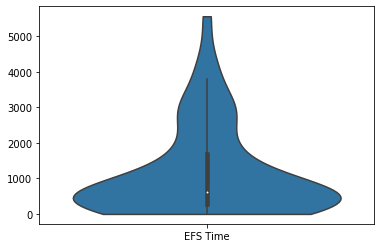

In [8]:
Trk_low_efs = Trk_low[['EFS Time']].astype(float)
Trk_moderate_efs = Trk_moderate[['EFS Time']].astype(float)
Trk_high_efs = Trk_high[['EFS Time']].astype(float)

import seaborn as sns
sns.violinplot(data=Trk_low_efs, cut=0)

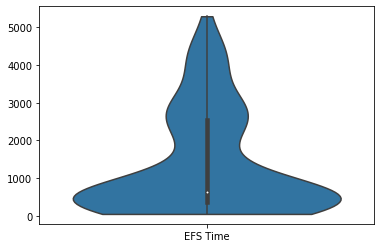

In [9]:
sns.violinplot(data=Trk_moderate_efs, cut=0)

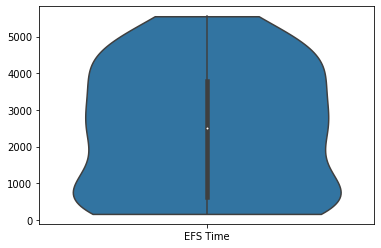

In [10]:
sns.violinplot(data=Trk_high_efs, cut=0)

(-2.5, 3.5)

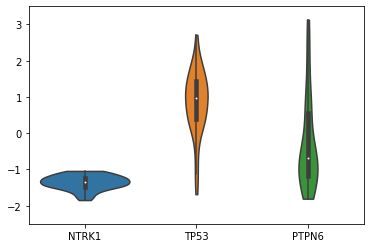

In [127]:
Trk_low_genes = Trk_low[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=Trk_low_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

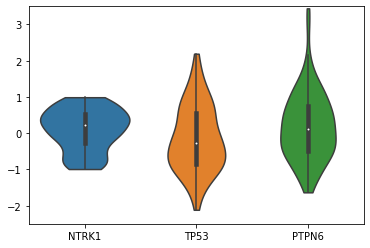

In [128]:
Trk_moderate_genes = Trk_moderate[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=Trk_moderate_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

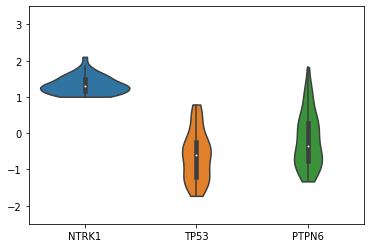

In [129]:
Trk_high_genes = Trk_high[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=Trk_high_genes, cut=0)
ax.set_ylim([-2.5,3.5])

### **SHP1/PTPN6**

In [57]:
ptpn6_low = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['PTPN6'] <= -1]
ptpn6_moderate = clinical_paper_genes_mrna_z.loc[(clinical_paper_genes_mrna_z['PTPN6'] > -1) & (clinical_paper_genes_mrna_z['PTPN6'] < 1)]
ptpn6_high = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['PTPN6'] >= 1]

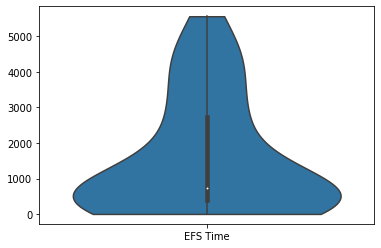

In [12]:
ptpn6_low_efs = ptpn6_low[['EFS Time']].astype(float)
ptpn6_moderate_efs = ptpn6_moderate[['EFS Time']].astype(float)
ptpn6_high_efs = ptpn6_high[['EFS Time']].astype(float)

import seaborn as sns
sns.violinplot(data=ptpn6_low_efs, cut=0)

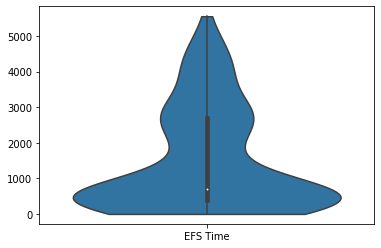

In [13]:
sns.violinplot(data=ptpn6_moderate_efs, cut=0)

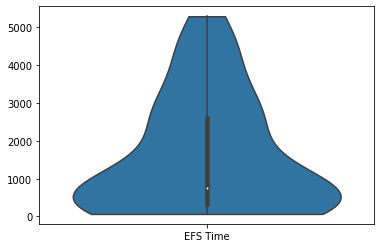

In [14]:
sns.violinplot(data=ptpn6_high_efs, cut=0)

(-2.5, 3.5)

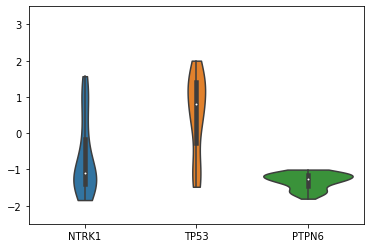

In [130]:
ptpn6_low_genes = ptpn6_low[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=ptpn6_low_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

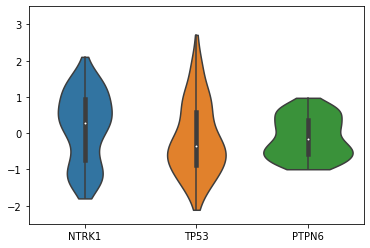

In [131]:
ptpn6_moderate_genes = ptpn6_moderate[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=ptpn6_moderate_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

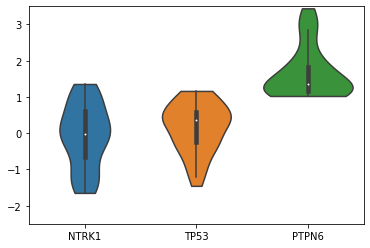

In [132]:
ptpn6_high_genes = ptpn6_high[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=ptpn6_high_genes, cut=0)
ax.set_ylim([-2.5,3.5])

### **TP53**

In [58]:
tp53_low = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['TP53'] <= -1]
tp53_moderate = clinical_paper_genes_mrna_z.loc[(clinical_paper_genes_mrna_z['TP53'] > -1) & (clinical_paper_genes_mrna_z['TP53'] < 1)]
tp53_high = clinical_paper_genes_mrna_z.loc[clinical_paper_genes_mrna_z['TP53'] >= 1]

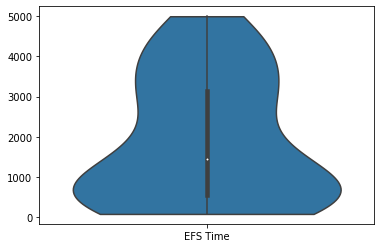

In [16]:
tp53_low_efs = tp53_low[['EFS Time']].astype(float)
tp53_moderate_efs = tp53_moderate[['EFS Time']].astype(float)
tp53_high_efs = tp53_high[['EFS Time']].astype(float)

import seaborn as sns
sns.violinplot(data=tp53_low_efs, cut=0)

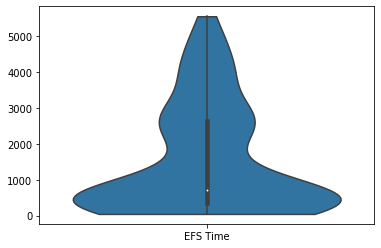

In [17]:
sns.violinplot(data=tp53_moderate_efs, cut=0)

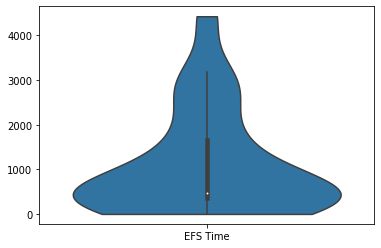

In [18]:
sns.violinplot(data=tp53_high_efs, cut=0)

(-2.5, 3.5)

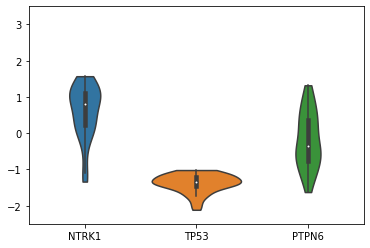

In [134]:
tp53_low_genes = tp53_low[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=tp53_low_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

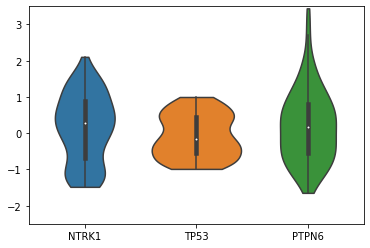

In [133]:
tp53_moderate_genes = tp53_moderate[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=tp53_moderate_genes, cut=0)
ax.set_ylim([-2.5,3.5])

(-2.5, 3.5)

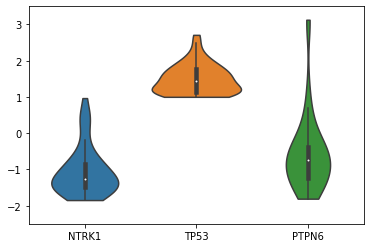

In [135]:
tp53_high_genes = tp53_high[['NTRK1', 'TP53', 'PTPN6']]
ax = sns.violinplot(data=tp53_high_genes, cut=0)
ax.set_ylim([-2.5,3.5])

### **Low TP53 & PTPN6**

In [59]:
ptpn6_tp53_low = clinical_paper_genes_mrna_z.loc[(clinical_paper_genes_mrna_z['PTPN6'] <= -1) & (clinical_paper_genes_mrna_z['TP53'] <= -1)]
ptpn6_tp53_low_efs = ptpn6_tp53_low[['EFS Time']].astype(float)

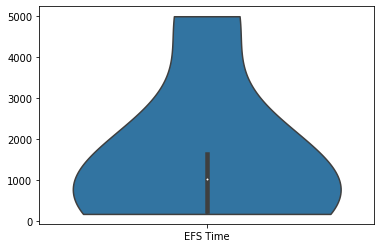

In [20]:
sns.violinplot(data=ptpn6_tp53_low_efs, cut=0)

In [21]:
ptpn6_tp53_low_efs

,EFS Time
44,4998.0
150,165.0
164,1638.0
207,425.0
225,1626.0
234,168.0


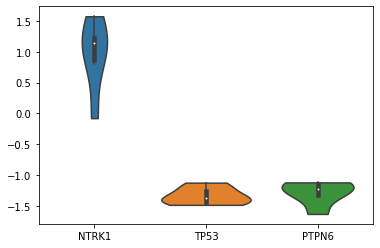

In [22]:
ptpn6_tp53_low_genes = ptpn6_tp53_low[['NTRK1', 'TP53', 'PTPN6']]
sns.violinplot(data=ptpn6_tp53_low_genes, cut=0)

## **Kaplan Meier**

### **TrkA**

In [25]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conve

Text(0, 0.5, 'Probability of survival')

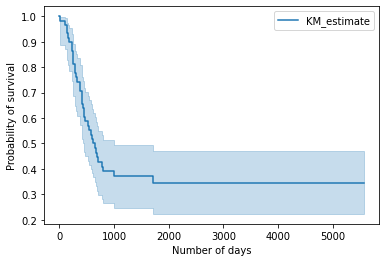

In [52]:
kmf = KaplanMeierFitter()
kmf.fit(durations =  Trk_low["EFS Time"], event_observed = Trk_low["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conve

Text(0, 0.5, 'Probability of survival')

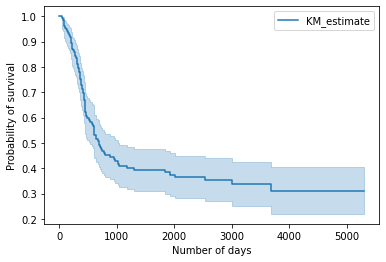

In [27]:
kmf = KaplanMeierFitter()
kmf.fit(durations =  Trk_moderate["EFS Time"], event_observed = Trk_moderate["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conve

Text(0, 0.5, 'Probability of survival')

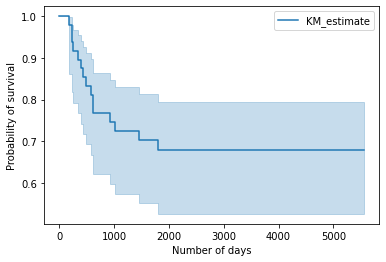

In [28]:
kmf = KaplanMeierFitter()
kmf.fit(durations =  Trk_high["EFS Time"], event_observed = Trk_high["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

In [29]:
from lifelines.statistics import logrank_test
results=logrank_test(Trk_low["EFS Time"].astype(float), Trk_high["EFS Time"].astype(float), event_observed_A=Trk_low["dead"], event_observed_B=Trk_high["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.52 <0.005     11.28

In [30]:
results=logrank_test(Trk_moderate["EFS Time"].astype(float), Trk_high["EFS Time"].astype(float), event_observed_A=Trk_moderate["dead"], event_observed_B=Trk_high["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          14.65 <0.005     12.92

### **TP53**

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conve

Text(0, 0.5, 'Probability of survival')

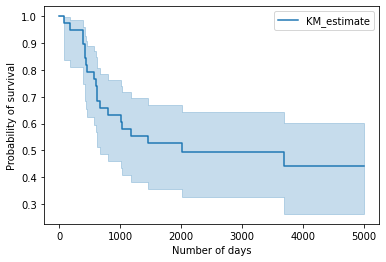

In [31]:
kmf = KaplanMeierFitter()
kmf.fit(durations = tp53_low["EFS Time"], event_observed = tp53_low["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Text(0, 0.5, 'Probability of survival')

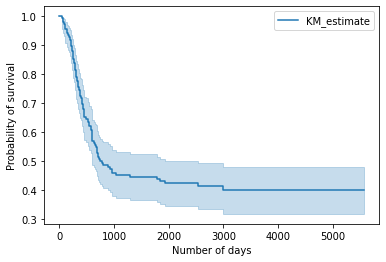

In [32]:
kmf = KaplanMeierFitter()
kmf.fit(durations = tp53_moderate["EFS Time"], event_observed = tp53_moderate["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Text(0, 0.5, 'Probability of survival')

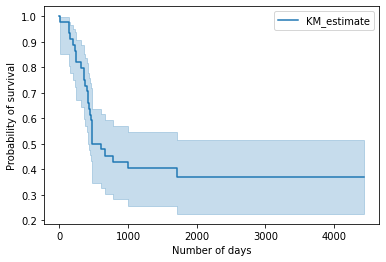

In [33]:
#tp53_high = tp53_high.drop(tp53_high.loc[tp53_high["#Patient Identifier"] == "TARGET-30-PAJXLE"].index)

kmf = KaplanMeierFitter()
kmf.fit(durations = tp53_high["EFS Time"], event_observed = tp53_high["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

In [34]:
results=logrank_test(tp53_low["EFS Time"].astype(float), tp53_high["EFS Time"].astype(float), event_observed_A=tp53_low["dead"], event_observed_B=tp53_high["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.71 0.10      3.32

In [35]:
results=logrank_test(tp53_low["EFS Time"].astype(float), tp53_moderate["EFS Time"].astype(float), event_observed_A=tp53_low["dead"], event_observed_B=tp53_moderate["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.49 0.22      2.17

In [36]:
results=logrank_test(tp53_high["EFS Time"].astype(float), tp53_moderate["EFS Time"].astype(float), event_observed_A=tp53_high["dead"], event_observed_B=tp53_moderate["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.97

### **SHP1**

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conve

Text(0, 0.5, 'Probability of survival')

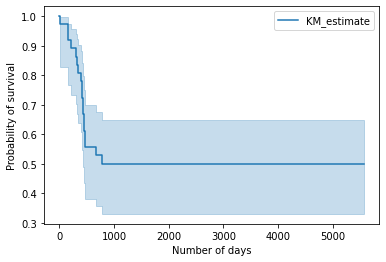

In [37]:
kmf = KaplanMeierFitter()
kmf.fit(durations = ptpn6_low["EFS Time"], event_observed = ptpn6_low["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Text(0, 0.5, 'Probability of survival')

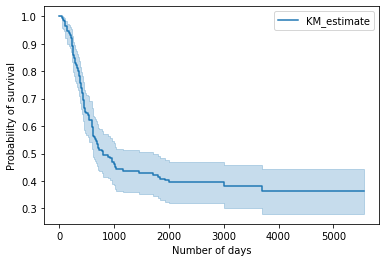

In [38]:
#ptpn6_moderate = ptpn6_moderate.drop(ptpn6_moderate.loc[ptpn6_moderate["#Patient Identifier"] == "TARGET-30-PAJXLE"].index)

kmf = KaplanMeierFitter()
kmf.fit(durations = ptpn6_moderate["EFS Time"], event_observed = ptpn6_moderate["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


Text(0, 0.5, 'Probability of survival')

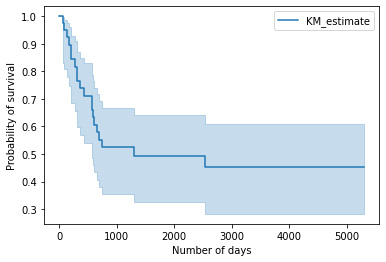

In [39]:
#ptpn6_high = ptpn6_high.drop(ptpn6_high.loc[ptpn6_high["#Patient Identifier"] == "TARGET-30-PACPJG"].index)

kmf = KaplanMeierFitter()
kmf.fit(durations = ptpn6_high["EFS Time"], event_observed = ptpn6_high["dead"])

kmf.plot()
plt.xlabel("Number of days")
plt.ylabel("Probability of survival")

In [40]:
results=logrank_test(ptpn6_low["EFS Time"].astype(float), ptpn6_moderate["EFS Time"].astype(float), event_observed_A=ptpn6_low["dead"], event_observed_B=ptpn6_moderate["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.59 0.44      1.18

In [41]:
results=logrank_test(ptpn6_low["EFS Time"].astype(float), ptpn6_high["EFS Time"].astype(float), event_observed_A=ptpn6_low["dead"], event_observed_B=ptpn6_high["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.17

In [42]:
results=logrank_test(ptpn6_moderate["EFS Time"].astype(float), ptpn6_high["EFS Time"].astype(float), event_observed_A=ptpn6_moderate["dead"], event_observed_B=ptpn6_high["dead"])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.39 0.53      0.91

### **MYCN**

**TrkA**

In [111]:
Trk_low_mycamp = Trk_low['MYCN'].value_counts(normalize=True)
Trk_moderate_mycamp = Trk_moderate['MYCN'].value_counts(normalize=True)
Trk_high_mycamp = Trk_high['MYCN'].value_counts(normalize=True)

In [112]:
Trk_mycamp = pd.DataFrame({'Expression':['low', 'moderate', 'high'], '% MYCN Apmlification':[Trk_low_mycamp[0], Trk_moderate_mycamp[1], 0]})

(0.0, 1.0)

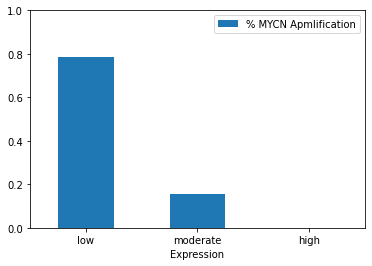

In [113]:
ax = Trk_mycamp.plot.bar(x='Expression', y='% MYCN Apmlification', rot=0)
ax.set_ylim(0,1.0)

**TP53**

In [95]:
tp53_low_mycamp = tp53_low['MYCN'].value_counts(normalize=True)
tp53_moderate_mycamp = tp53_moderate['MYCN'].value_counts(normalize=True)
tp53_high_mycamp = tp53_high['MYCN'].value_counts(normalize=True)

In [106]:
tp53_mycamp = pd.DataFrame({'Expression':['low', 'moderate', 'high'], '% MYCN Apmlification':[tp53_low_mycamp[1], tp53_moderate_mycamp[1], tp53_high_mycamp[0]]})

(0.0, 1.0)

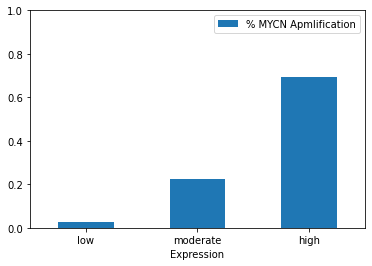

In [110]:
ax = tp53_mycamp.plot.bar(x='Expression', y='% MYCN Apmlification', rot=0)
ax.set_ylim(0,1.0)

**PTPN6**

In [114]:
ptpn6_low_mycamp = ptpn6_low['MYCN'].value_counts(normalize=True)
ptpn6_moderate_mycamp = ptpn6_moderate['MYCN'].value_counts(normalize=True)
ptpn6_high_mycamp = ptpn6_high['MYCN'].value_counts(normalize=True)

In [115]:
ptpn6_mycamp = pd.DataFrame({'Expression':['low', 'moderate', 'high'], '% MYCN Apmlification':[ptpn6_low_mycamp[0], ptpn6_moderate_mycamp[1], ptpn6_high_mycamp[1]]})

(0.0, 1.0)

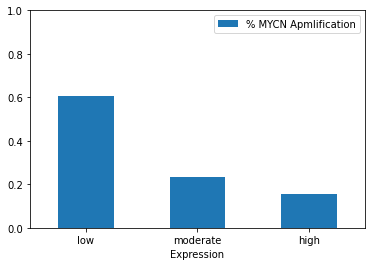

In [116]:
ax = ptpn6_mycamp.plot.bar(x='Expression', y='% MYCN Apmlification', rot=0)
ax.set_ylim(0,1.0)

### **Cox Regression Hazard Model**

In [43]:
from lifelines import CoxPHFitter

In [60]:
kmf = KaplanMeierFitter()
kmf.fit(Trk_low["EFS Time"], event_observed = Trk_low["dead"])

cph = CoxPHFitter()
Trk_low_data = Trk_low[["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"]]
cph.fit(Trk_low_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 60 total observations, 23 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 60
number of events observed = 37
   partial log-likelihood = -111.97
         time fit was run = 2021-02-04 09:32:52 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology             -0.03       0.97       0.24            -0.50             0.43                 0.61                 1.54
Sex_binary            -0.02       0.98       0.37            -0.75             0.70                 0.47                 2.02
mycn_binary            0.14       1.16       0.47            -0.77             1.06                 0.46                 2.90

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  0.28 0.78       0.36
Histology            -0.14 0.89       0.17
Sex_binary           -0.06 0.95       0.07
mycn_binary           0.31 0.76       0.40
---
Concordance = 0.53
Partial AIC = 231.95
log-likelihood ratio test = 0.20 on 4 df
-log2(p) of ll-ratio test = 0.01

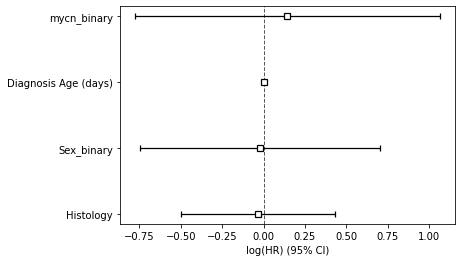

In [45]:
cph.plot() #Almost all stage 4 - Stage 4: 58, Stage 3: 1, Stage 1: 1

In [61]:
Trk_moderate = Trk_moderate.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(Trk_moderate["EFS Time"], event_observed = Trk_moderate["dead"])

cph = CoxPHFitter()
Trk_moderate_data = Trk_moderate[["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"]]
cph.fit(Trk_moderate_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 134 total observations, 49 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 134
number of events observed = 85
   partial log-likelihood = -320.62
         time fit was run = 2021-02-04 09:32:56 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology              0.18       1.20       0.11            -0.03             0.39                 0.97                 1.47
Sex_binary            -0.35       0.71       0.23            -0.81             0.11                 0.45                 1.12
mycn_binary            0.18       1.20       0.31            -0.42             0.79                 0.66                 2.20

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  1.63 0.10       3.28
Histology             1.69 0.09       3.47
Sex_binary           -1.47 0.14       2.83
mycn_binary           0.60 0.55       0.86
---
Concordance = 0.54
Partial AIC = 649.25
log-likelihood ratio test = 5.45 on 4 df
-log2(p) of ll-ratio test = 2.03

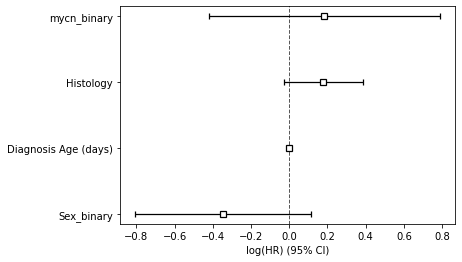

In [47]:
cph.plot() #Almost all stage 4 - Stage 4: 127, Stage 1: 7

In [137]:
Trk_high = Trk_high.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(Trk_high["EFS Time"], event_observed = Trk_high["dead"])

cph = CoxPHFitter()
Trk_high_data = Trk_high[["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "dead"]]#"mycn_binary",
cph.fit(Trk_high_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 49 total observations, 34 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 15
   partial log-likelihood = -36.64
         time fit was run = 2021-02-04 11:24:55 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology             -0.74       0.48       0.58            -1.88             0.41                 0.15                 1.50
Sex_binary            -1.56       0.21       0.68            -2.89            -0.23                 0.06                 0.80

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  0.38 0.71       0.50
Histology            -1.26 0.21       2.27
Sex_binary           -2.30 0.02       5.53
---
Concordance = 0.70
Partial AIC = 79.28
log-likelihood ratio test = 7.22 on 3 df
-log2(p) of ll-ratio test = 3.94

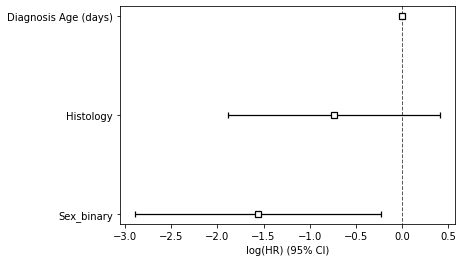

In [136]:
cph.plot() #all not amplified

In [142]:
tp53_low = tp53_low.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(tp53_low["EFS Time"], event_observed = tp53_low["dead"])

cph = CoxPHFitter()
tp53_low_data = tp53_low[["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "mycn_binary", "Sex_binary", "dead"]]
cph.fit(tp53_low_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 40 total observations, 20 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 40
number of events observed = 20
   partial log-likelihood = -42.68
         time fit was run = 2021-02-04 11:26:15 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Histology             -0.21       0.81       0.42            -1.04             0.62                 0.35                 1.85
mycn_binary            0.33       1.40       1.09            -1.81             2.48                 0.16                11.95
Sex_binary            -1.39       0.25       0.67            -2.70            -0.09                 0.07                 0.91

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  2.02 0.04       4.53
Histology            -0.51 0.61       0.71
mycn_binary           0.31 0.76       0.40
Sex_binary           -2.09 0.04       4.79
---
Concordance = 0.58
Partial AIC = 93.35
log-likelihood ratio test = 13.22 on 4 df
-log2(p) of ll-ratio test = 6.61

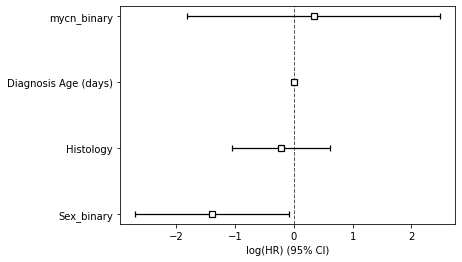

In [143]:
cph.plot() #Almost all stage 4 - Stage 4: 32, Stage 1: 8

In [150]:
tp53_moderate = tp53_moderate.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(tp53_moderate["EFS Time"], event_observed = tp53_moderate["dead"])

cph = CoxPHFitter()
tp53_moderate_data = tp53_moderate[["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "mycn_binary", "Sex_binary", "dead"]]
cph.fit(tp53_moderate_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 157 total observations, 67 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 157
number of events observed = 90
   partial log-likelihood = -350.69
         time fit was run = 2021-02-04 11:27:38 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology              0.18       1.19       0.10            -0.03             0.38                 0.98                 1.46
mycn_binary            0.36       1.43       0.25            -0.13             0.84                 0.88                 2.32
Sex_binary            -0.22       0.81       0.23            -0.66             0.23                 0.52                 1.26

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  0.79 0.43       1.23
Histology             1.72 0.09       3.54
mycn_binary           1.45 0.15       2.76
Sex_binary           -0.94 0.34       1.54
---
Concordance = 0.57
Partial AIC = 709.38
log-likelihood ratio test = 5.45 on 4 df
-log2(p) of ll-ratio test = 2.03

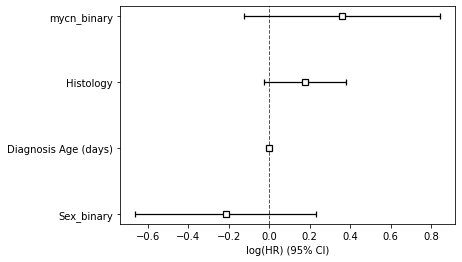

In [151]:
cph.plot() #almost all stage 4 - stage 4: 134, stage 3: 1, stage 1: 22

In [154]:
tp53_high = tp53_high.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(tp53_high["EFS Time"], event_observed = tp53_high["dead"])

cph = CoxPHFitter()
tp53_high_data = tp53_high[["Diagnosis Age (days)", "Histology", #"Stage", #all stage 4
                                  'EFS Time', "mycn_binary", "Sex_binary", "dead"]]
cph.fit(tp53_high_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 46 total observations, 19 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 46
number of events observed = 27
   partial log-likelihood = -73.86
         time fit was run = 2021-02-04 11:28:31 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology             -0.58       0.56       0.61            -1.79             0.62                 0.17                 1.86
mycn_binary           -0.27       0.76       0.47            -1.20             0.66                 0.30                 1.93
Sex_binary            -0.29       0.75       0.41            -1.10             0.51                 0.33                 1.67

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  1.05 0.29       1.77
Histology            -0.95 0.34       1.54
mycn_binary          -0.57 0.57       0.82
Sex_binary           -0.71 0.48       1.07
---
Concordance = 0.64
Partial AIC = 155.71
log-likelihood ratio test = 4.23 on 4 df
-log2(p) of ll-ratio test = 1.41

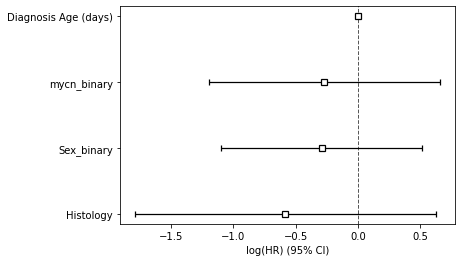

In [157]:
cph.plot() #all stage 4

In [166]:
ptpn6_low = ptpn6_low.dropna(subset=["Diagnosis Age (days)", "Histology", #"Stage",
                                  'EFS Time', "Sex_binary", "mycn_binary", "dead"])

kmf = KaplanMeierFitter()
kmf.fit(ptpn6_low["EFS Time"], event_observed = ptpn6_low["dead"])

cph = CoxPHFitter()
ptpn6_low_data = ptpn6_low[["Diagnosis Age (days)", "Histology", #"Stage", #all stage 4
                                  'EFS Time', "mycn_binary", "Sex_binary", "dead"]]
cph.fit(ptpn6_low_data, 'EFS Time', event_col='dead')
cph.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1175: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column Histology have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['dead'].astype(bool)
>>> print(df.loc[events, 'Histology'].var())
>>> print(df.loc[~events, 'Histology'].var())

A very low variance means that the column Histology completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), Converge

<lifelines.CoxPHFitter: fitted with 38 total observations, 20 right-censored observations>
             duration col = 'EFS Time'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 38
number of events observed = 18
   partial log-likelihood = -44.25
         time fit was run = 2021-02-04 11:39:50 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Diagnosis Age (days)   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Histology            -16.28       0.00    3201.39         -6290.89          6258.32                 0.00                  inf
mycn_binary           -0.03       0.97       0.59            -1.20             1.13                 0.30                 3.09
Sex_binary            -0.23       0.79       0.50            -1.22             0.76                 0.30                 2.13

                         z    p   -log2(p)
covariate                                 
Diagnosis Age (days)  0.02 0.99       0.02
Histology            -0.01 1.00       0.01
mycn_binary          -0.06 0.95       0.07
Sex_binary           -0.46 0.65       0.63
---
Concordance = 0.63
Partial AIC = 96.50
log-likelihood ratio test = 4.61 on 4 df
-log2(p) of ll-ratio test = 1.60

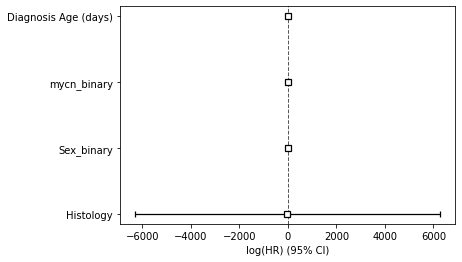

In [167]:
cph.plot() #all stage 4

In [170]:
ptpn6_low['Histology'].value_counts()

0.0    34
1.0     3
3.0     1
Name: Histology, dtype: int64